In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.data_loader import load_rfm_data
from src.config.config_loader import get_config

plt.rcParams["font.family"] = "Tahoma"

df = pd.read_csv("../data/customer_clusters.csv")
df.head()

,CustomerCode,Cluster
0,C20010368,3
1,C20010439,2
2,C20010518,2
3,C20010657,0
4,C20010663,0


In [3]:
config = get_config()
cols = config["rfm_columns"]
ref_date = datetime.strptime(config["recency_reference_date"], "%Y-%m-%d")

full_data = load_rfm_data()

entry_dates = pd.to_datetime(full_data[cols["recency"]], errors="coerce")
recency_days = (ref_date - entry_dates).dt.days

analysis_df = pd.DataFrame({
    cols["customer_id"]: full_data[cols["customer_id"]],
    "Recency": recency_days,
    "Frequency": full_data[cols["frequency"]],
    "Monetary": full_data[cols["monetary"]],
    "ReturnRate": full_data[cols["return_rate"]],
})

cluster_df = pd.read_csv("../data/customer_clusters.csv")
merged = pd.merge(cluster_df, analysis_df, on=cols["customer_id"])
merged.head()



{"timestamp": "2025-09-01T01:49:12", "level": "INFO", "module": "src.data_loader", "message": "Starting to load RFM data from SQL"}
{"timestamp": "2025-09-01T01:49:12", "level": "INFO", "module": "src.data_loader", "message": "Connecting to SQL Server: ., Database: Uni, Table: CustomerData"}
{"timestamp": "2025-09-01T01:49:12", "level": "INFO", "module": "src.data_loader", "message": "RFM data loaded successfully. Shape: (1649, 6)"}


,CustomerCode,Cluster,Recency,Frequency,Monetary,ReturnRate
0,C20010368,3,300,4,13386132,0.00
1,C20010439,2,0,36,133224272,16.28
2,C20010518,2,18,9,74331195,18.18
3,C20010657,0,22,16,71577619,0.00
4,C20010663,0,30,4,19447647,0.00


In [ ]:
stats = merged.groupby("Cluster").agg({
    "Recency":  ["mean"],
    "Frequency": ["mean"],
    "Monetary": ["mean"],
    "ReturnRate": ["mean"],
    "CustomerCode": "count"
}).rename(columns={"CustomerCode": "Count"})

stats

,Recency,Frequency,Monetary,ReturnRate,Count
,mean,mean,mean,mean,count
Cluster,,,,,
0,30.930172,30.961207,1.606318e+08,1.515569,1160
1,19.953488,280.558140,1.264413e+10,4.132093,43
2,37.666667,29.602694,1.050261e+08,19.839697,297
3,222.543624,14.483221,9.314088e+07,2.065570,149


C:\Users\Soheil\AppData\Local\Temp\ipykernel_20696\252563791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="Cluster", y=col, palette="Set2")


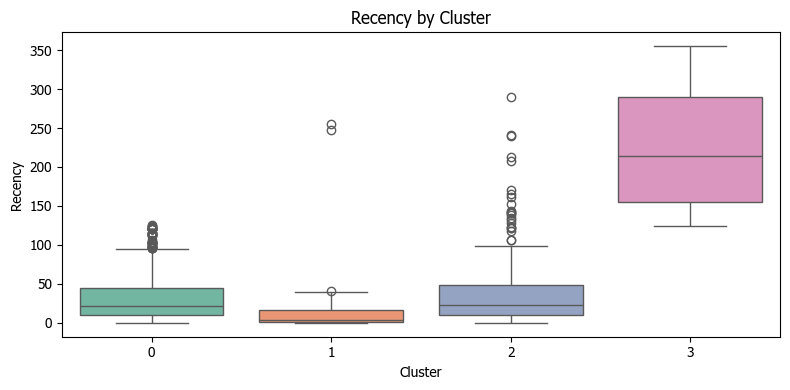

C:\Users\Soheil\AppData\Local\Temp\ipykernel_20696\252563791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="Cluster", y=col, palette="Set2")


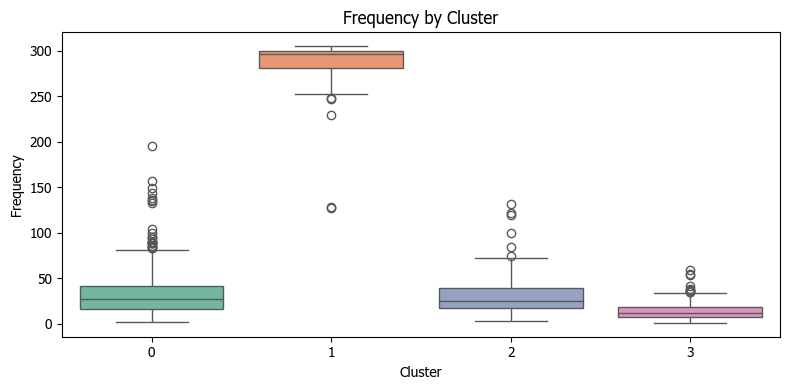

C:\Users\Soheil\AppData\Local\Temp\ipykernel_20696\252563791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="Cluster", y=col, palette="Set2")


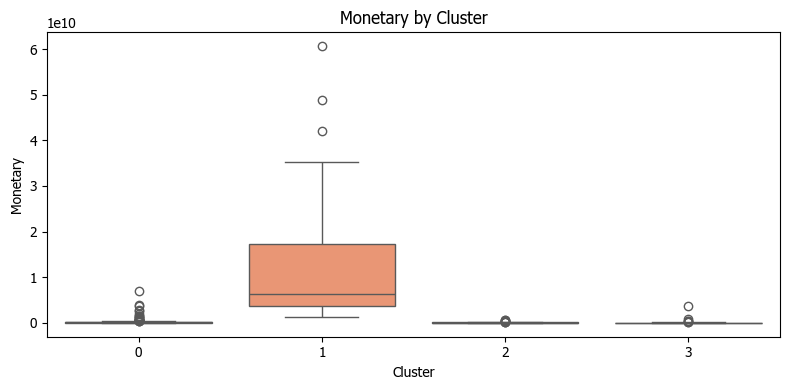

C:\Users\Soheil\AppData\Local\Temp\ipykernel_20696\252563791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="Cluster", y=col, palette="Set2")


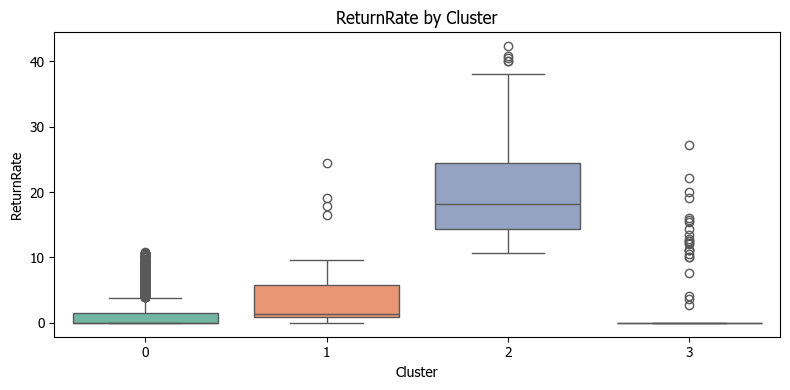

In [8]:
features = ["Recency", "Frequency", "Monetary", "ReturnRate"]

for col in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=merged, x="Cluster", y=col, palette="Set2")
    plt.title(f"{col} by Cluster")
    plt.tight_layout()
    plt.show()

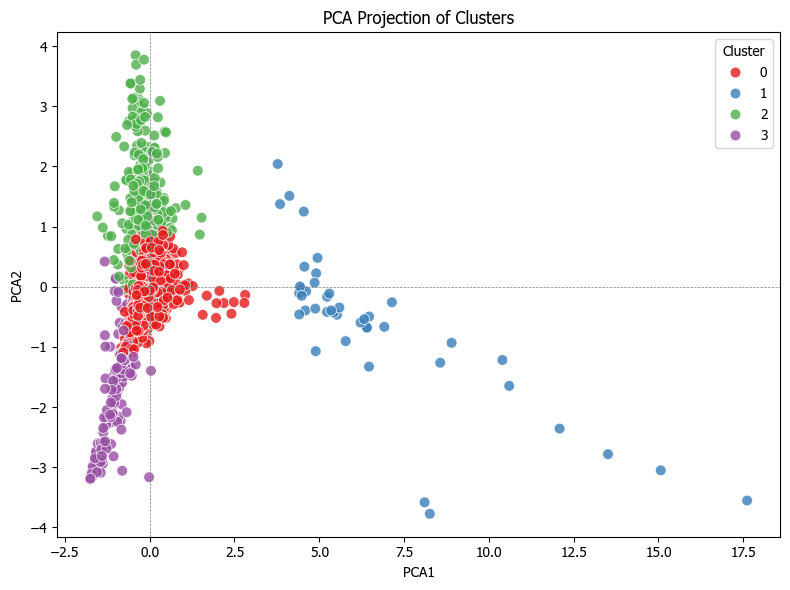

In [10]:
X = merged[features]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

merged["PCA1"] = pca_result[:, 0]
merged["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged, x="PCA1", y="PCA2", hue="Cluster", palette="Set1", s=60, alpha=0.8)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.5)
plt.title("PCA Projection of Clusters")
plt.tight_layout()
plt.show()

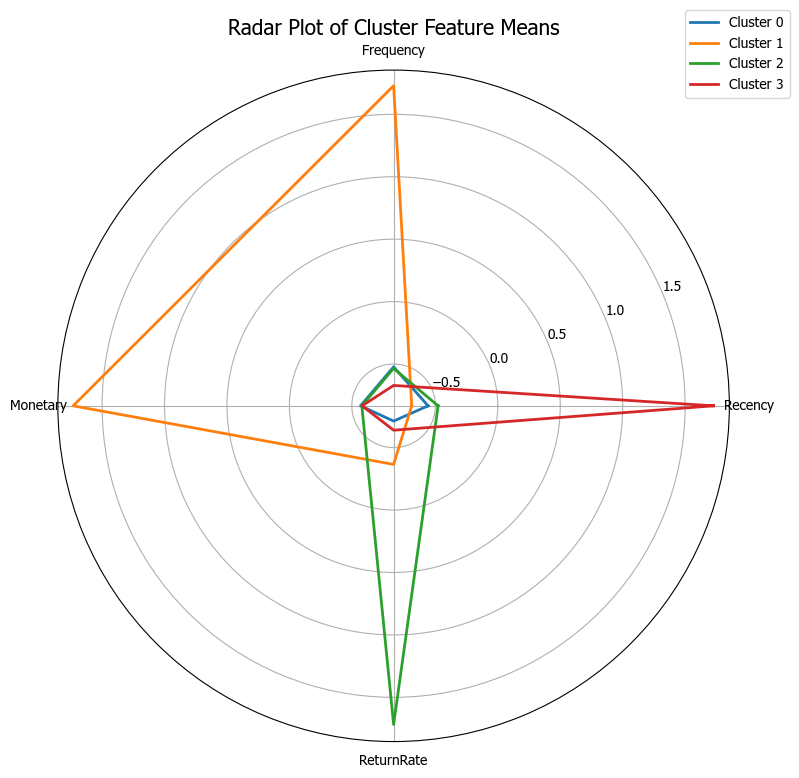

In [12]:
radar_data = merged.groupby("Cluster")[features].mean()
radar_scaled = StandardScaler().fit_transform(radar_data)
radar_df = pd.DataFrame(radar_scaled, columns=features, index=radar_data.index)

categories = features
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  

plt.figure(figsize=(8, 8))
for i, row in radar_df.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {i}", linewidth=2)

plt.xticks(angles[:-1], categories)
plt.title("Radar Plot of Cluster Feature Means", size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


In [14]:
overall_means = merged[features].mean()
group_means = merged.groupby("Cluster")[features].mean()

for cluster_id, row in group_means.iterrows():
    print(f"📦 Cluster {cluster_id}:")

    for feature in features:
        if row[feature] > overall_means[feature]:
            print(f"🔼 {feature} بالاتر از میانگین کل ({row[feature]:.2f})")
        else:
            print(f"🔽 {feature} پایین‌تر از میانگین کل ({row[feature]:.2f})")

    print("-" * 50)


📦 Cluster 0:
🔽 Recency پایین‌تر از میانگین کل (30.93)
🔽 Frequency پایین‌تر از میانگین کل (30.96)
🔽 Monetary پایین‌تر از میانگین کل (160631811.71)
🔽 ReturnRate پایین‌تر از میانگین کل (1.52)
--------------------------------------------------
📦 Cluster 1:
🔽 Recency پایین‌تر از میانگین کل (19.95)
🔼 Frequency بالاتر از میانگین کل (280.56)
🔼 Monetary بالاتر از میانگین کل (12644130719.60)
🔽 ReturnRate پایین‌تر از میانگین کل (4.13)
--------------------------------------------------
📦 Cluster 2:
🔽 Recency پایین‌تر از میانگین کل (37.67)
🔽 Frequency پایین‌تر از میانگین کل (29.60)
🔽 Monetary پایین‌تر از میانگین کل (105026073.13)
🔼 ReturnRate بالاتر از میانگین کل (19.84)
--------------------------------------------------
📦 Cluster 3:
🔼 Recency بالاتر از میانگین کل (222.54)
🔽 Frequency پایین‌تر از میانگین کل (14.48)
🔽 Monetary پایین‌تر از میانگین کل (93140882.15)
🔽 ReturnRate پایین‌تر از میانگین کل (2.07)
--------------------------------------------------
